In [15]:
''' Import required libraries.
'''

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

from datasets import load_dataset

Download the MNIST dataset from [https://huggingface.co/datasets/mnist](https://huggingface.co/datasets/mnist). Use a random set of $100$ images chosen from each class $(0$ to $9)$ as your dataset.

In [16]:
''' Download the MNIST dataset.
'''

# Load MNIST dataset
dataset = load_dataset("mnist")

Shapes:
X_train: (1000, 28, 28),
flattened_X: (1000, 784),
y_train: (1000,)


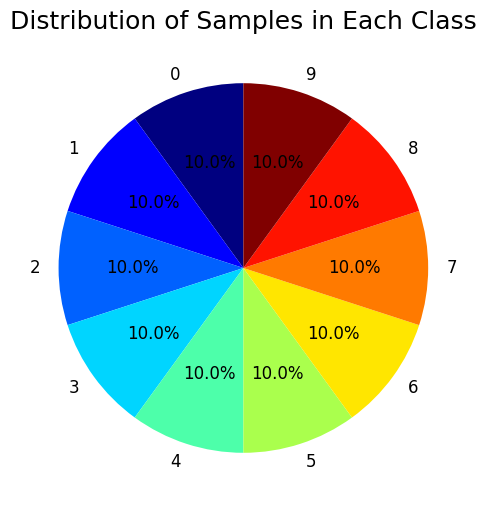

In [17]:
'''Extract a random set of 100 images for each label
'''

# Set a seed for reproducibility
seed = 87
np.random.seed(seed)

# Split the dataset: features- labels
X_train = np.array([np.array(image) for image in dataset['train']['image']])
y_train = np.array(dataset['train']['label'])

# Convert <class 'PIL.PngImagePlugin.PngImageFile'> to numpy array
X_train_array = np.array([np.array(img) for img in X_train])

# Number of samples per class
samples_per_class = 100

# Create a mask for each class and select 100 random indices
indices = np.concatenate([np.random.choice(np.where(y_train == class_label)[0], samples_per_class, replace=False)
                          if len(np.where(y_train == class_label)[0]) >= samples_per_class
                          else np.where(y_train == class_label)[0]
                          for class_label in range(10)])

# Check if any indices were selected
if indices.size == 0:
    raise ValueError("Not enough samples per class. Adjust 'samples_per_class' or use a larger dataset.")

# Use the selected indices to create the final subset
X_train = X_train[indices]
y_train = y_train[indices]

# Shuffle the final subset
shuffle_indices = np.random.permutation(len(X_train))
X_train = X_train[shuffle_indices]
y_train = y_train[shuffle_indices]

# Capture the original shape of an individual data point
original_shape = X_train[0].shape

# Flatten the datapoint
flattened_X = np.array([entry.flatten() for entry in X_train])

# Print the shapes
print("Shapes:\nX_train: {},\nflattened_X: {},\ny_train: {}".format(X_train.shape, flattened_X.shape, y_train.shape))

# Count the number of samples in each class in the subset
class_counts = np.bincount(y_train)

# Get the labels for classes present in the subset
class_labels = np.where(class_counts > 0)[0]

# Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(class_counts[class_labels], labels=class_labels, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 12}, colors=plt.cm.jet(np.linspace(0, 1, len(class_labels))))
plt.title('Distribution of Samples in Each Class', fontsize=18)
plt.show()


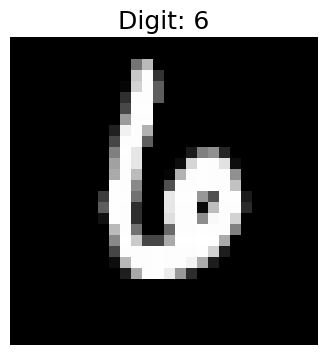

In [18]:
''' Display a random image
'''

# Set a seed for reproducibility
seed = 87
np.random.seed(seed)

# Choose a random index from the subset
random_index = np.random.randint(0, len(X_train))

# Display the random image
plt.figure(figsize=(4, 4))
plt.imshow(X_train[random_index], cmap='gray')
plt.title(f"Digit: {y_train[random_index]}", fontsize=18)
plt.axis('off')
# Save the plot or image as a PDF file
plt.savefig("images/problem-1/random-digit.pdf")

plt.show()

1. Write a piece of code to run the PCA algorithm on this dataset. Show the images of the principal components that you obtain. How much of the variance in the dataset is explained by each of the principal components?

In [19]:
''' Principal Component Analysis
'''

class PCA:
    def __init__(self, n_components):
        self.X_fit = None
        self.n_components = n_components
        self.total_components = None
        self.components = None
        self.eigenvectors = None
        self.eigenvalues = None
        self.covariance_matrix = None
        self.mean = None
        self.std = None
        self.original_shape = None
        self.explained_variance_ratio = None
        self.cumulative_variance_ratio = None

    def _centralize_data_(self, X):
        mean = np.mean(X, axis=0)
        std = np.std(X, axis=0)
        centered_X = (X - mean)
        normalized_X = (X - mean) / (std + 1e-10)  # Add a small value to avoid division by zero
        return centered_X, mean, std

    def _compute_covariance_matrix_(self, normalized_X):
        return np.cov(normalized_X, rowvar=False)

    def _compute_eigenvalues_and_vectors_(self, covariance_matrix):
        eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
        sorted_indices = np.argsort(eigenvalues)[::-1]
        return eigenvalues[sorted_indices], eigenvectors[:, sorted_indices]

    def _select_top_eigenvectors_(self, eigenvectors):
        return eigenvectors[:, :self.n_components]

    def fit_transform_(self, X):
        # Capture X_fit
        self.X_fit = X

        # Capture the total components
        self.total_components = self.X_fit[0].size

        # Normalize the data
        centered_X, self.mean, self.std = self._centralize_data_(self.X_fit)

        # Compute the covariance matrix
        self.covariance_matrix = self._compute_covariance_matrix_(centered_X)

        # Compute eigenvalues and eigenvectors
        self.eigenvalues, self.eigenvectors = self._compute_eigenvalues_and_vectors_(self.covariance_matrix)

        # Select the top n_components eigenvectors
        self.components = self._select_top_eigenvectors_(self.eigenvectors)

        # Project the data onto the new feature space
        transformed_X = centered_X.dot(self.components)

        return transformed_X

    def inverse_transform_(self, X_transformed):
        if self.X_fit is None:
            raise ValueError("Fit the model before attempting to inverse transform.")

        # Project the X back to the original space using components up to i
        reconstructed_X = X_transformed @ self.components.T

        # Denormalize the reconstructed data
        reconstructed_X = reconstructed_X + self.mean

        return reconstructed_X

    def explained_variance_(self):
        return self.eigenvalues[:self.n_components]

    def explained_variance_ratio_(self):
        total_variance = np.sum(self.eigenvalues)
        self.explained_variance_ratio = self.eigenvalues / total_variance
        return self.explained_variance_ratio[:self.n_components]

    def cumulative_variance_ratio_(self):
        self.explained_variance_ratio_()
        self.cumulative_variance_ratio = np.cumsum(self.explained_variance_ratio)
        return self.cumulative_variance_ratio[:self.n_components]

Original image shape:  (28, 28)


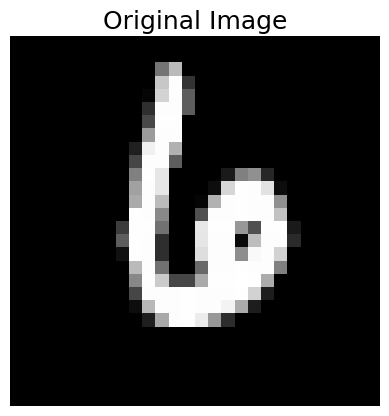

[231.]
Reconstucted image components:  784


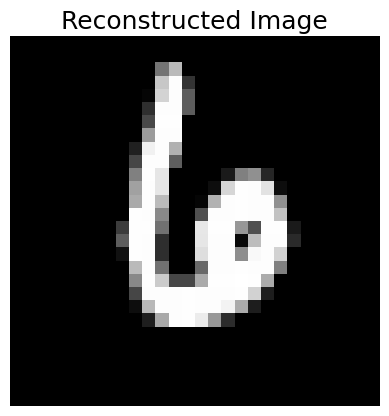

In [20]:
# Set a seed for reproducibility
seed = 87
np.random.seed(seed)

# Choose a random index
random_index = np.random.randint(0, len(X_train))

# Visualize the randomly selected original image
original_image = X_train[random_index]
print('Original image shape: ', original_image.shape)
plt.imshow(original_image, cmap='gray')
plt.title('Original Image', fontsize=18)
plt.savefig("images/problem-1/Original-image.pdf")
plt.axis('off')
plt.show()

# Create and apply PCA using the custom class
num_components = 784
pca = PCA(num_components)
data_pca = pca.fit_transform_(flattened_X)

# Reconstruct the randomly selected image after PCA
reconstructed_image = pca.inverse_transform_(data_pca[random_index])
reconstructed_image = reconstructed_image.reshape(*original_shape, -1)
print(reconstructed_image[14][14])
print('Reconstucted image components: ', num_components)
plt.imshow(reconstructed_image, cmap='gray')
plt.title('Reconstructed Image', fontsize=18)
plt.savefig("images/problem-1/Reconstructed-image.pdf")
plt.axis('off')
plt.show()

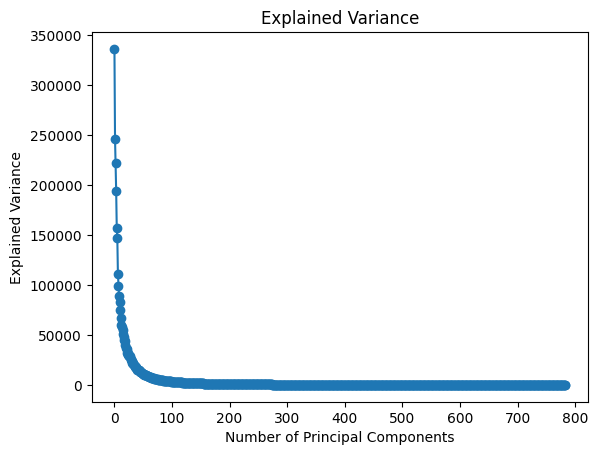

Principal Component 1: 336037.4646 explained variance
Principal Component 2: 246187.9788 explained variance
Principal Component 3: 222096.0762 explained variance
Principal Component 4: 193820.8358 explained variance
Principal Component 5: 157019.4640 explained variance
Principal Component 10: 82636.3438 explained variance
Principal Component 20: 39909.0109 explained variance
Principal Component 50: 11121.3021 explained variance
Principal Component 100: 3341.8100 explained variance
Principal Component 250: 532.4986 explained variance
Principal Component 500: 17.0491 explained variance
Principal Component 750: -0.0000 explained variance
Principal Component 784: -0.0000 explained variance


In [21]:
# Variance explained by each principal component
explained_variance = pca.explained_variance_()

# Plot the cumulative explained variance
plt.plot(np.arange(num_components), explained_variance, marker='o')
plt.title('Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance')
plt.savefig("images/problem-1/PCA-explained-variance.pdf")
plt.show()

indices = [1, 2, 3, 4, 5, 10, 20, 50, 100, 250, 500, 750, 784]
for i in range(len(indices)):
    print(f'Principal Component {indices[i]}: {explained_variance[indices[i]-1]:.4f} explained variance')

(784,)


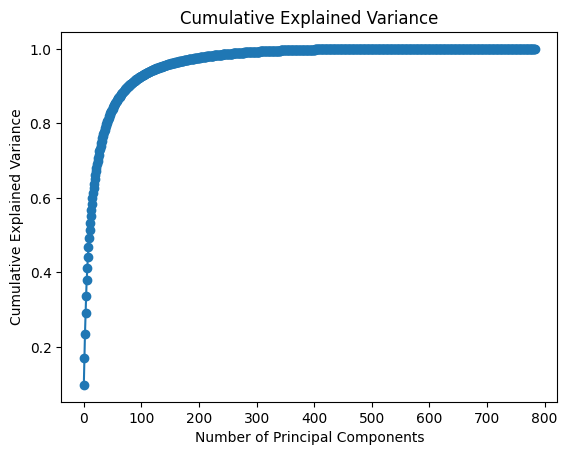

Principal Component 1: 0.0982 explained variance
Principal Component 2: 0.1701 explained variance
Principal Component 3: 0.2350 explained variance
Principal Component 4: 0.2916 explained variance
Principal Component 5: 0.3375 explained variance
Principal Component 10: 0.4921 explained variance
Principal Component 20: 0.6504 explained variance
Principal Component 50: 0.8368 explained variance
Principal Component 100: 0.9266 explained variance
Principal Component 250: 0.9864 explained variance
Principal Component 500: 0.9999 explained variance
Principal Component 750: 1.0000 explained variance
Principal Component 784: 1.0000 explained variance


In [22]:
# Variance explained by each principal component
explained_variance_ratio = pca.explained_variance_ratio_()
cumulative_variance_ratio = pca.cumulative_variance_ratio_()
print(cumulative_variance_ratio.shape)

# Plot the cumulative explained variance
plt.plot(np.arange(num_components), cumulative_variance_ratio, marker='o')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.savefig("images/problem-1/PCA-cumulative-variance-ratio.pdf")
plt.show()

indices = [1, 2, 3, 4, 5, 10, 20, 50, 100, 250, 500, 750, 784]
for i in range(len(indices)):
    print(f'Principal Component {indices[i]}: {cumulative_variance_ratio[indices[i]-1]:.4f} explained variance')

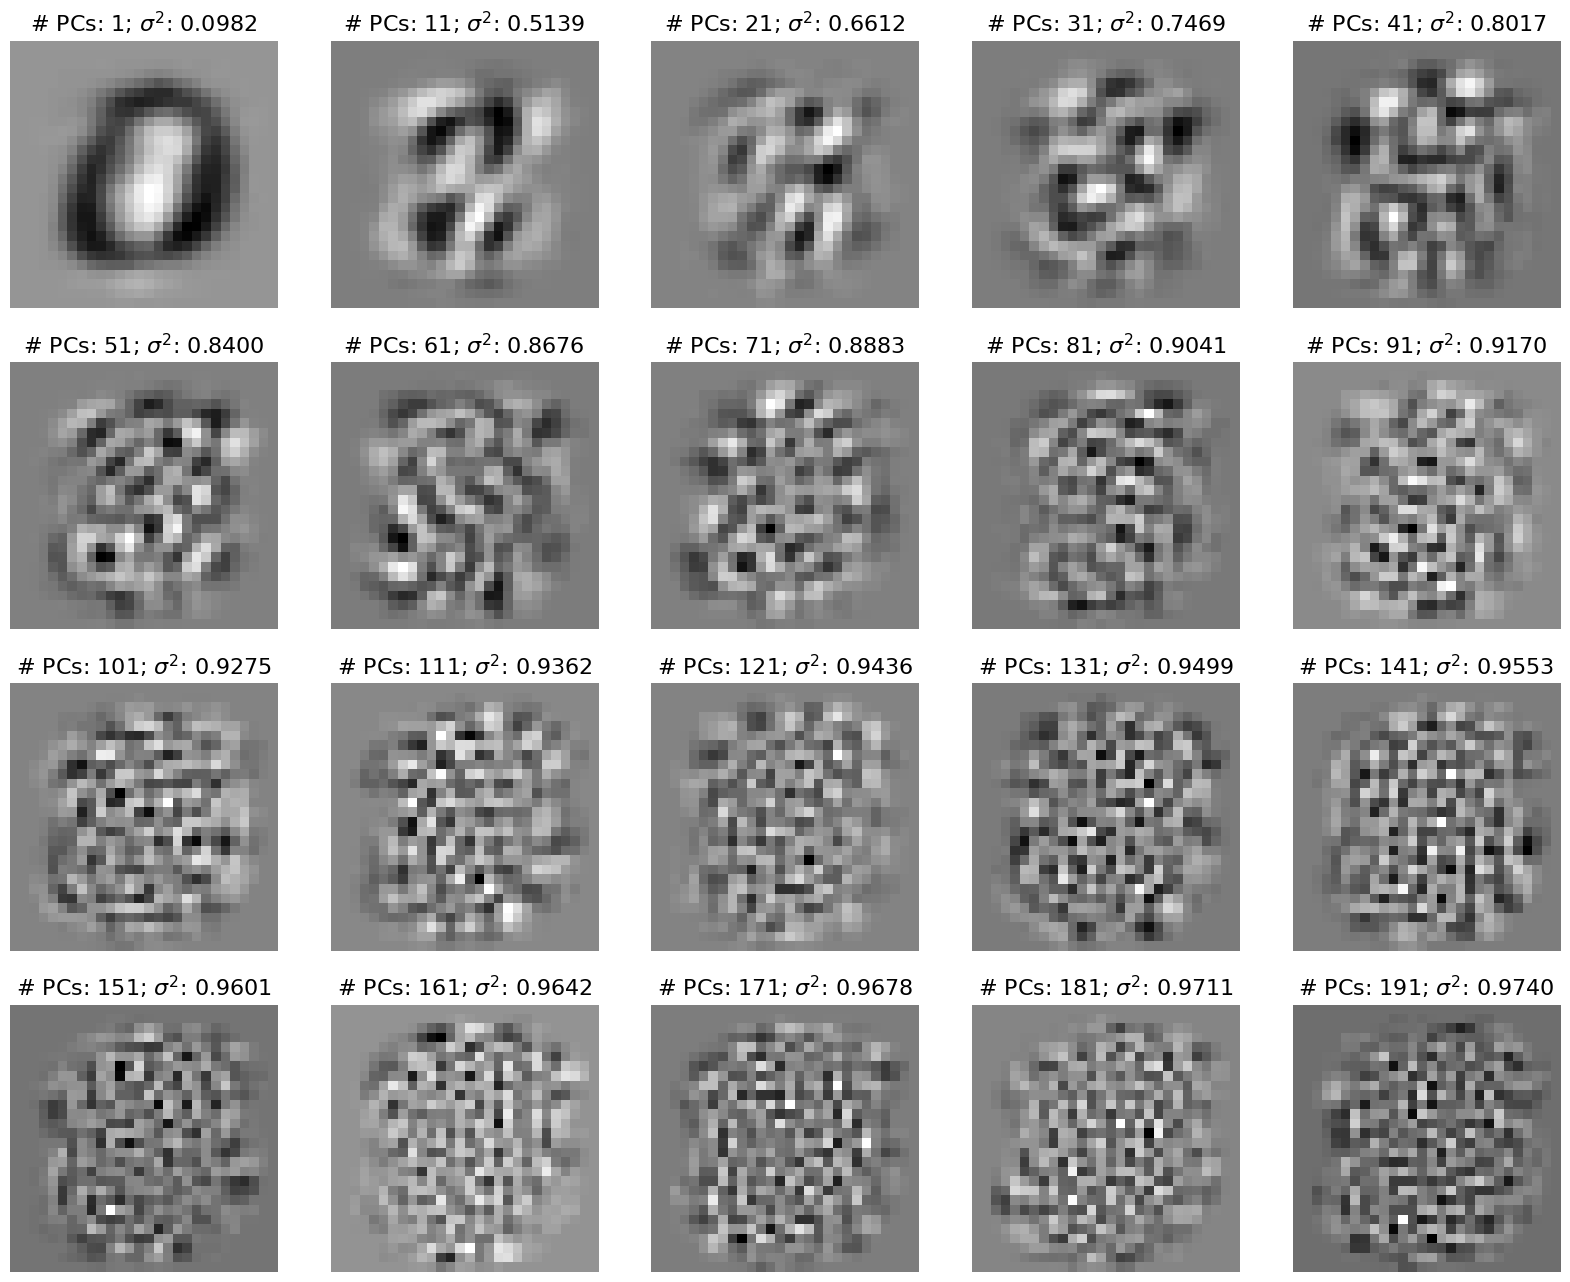

In [23]:
# Plot the first few principal components as images
fig, axes = plt.subplots(4, 5, figsize=(20, 16))
for i, ax in enumerate(axes.flat):
    num_components = 10*i + 1
    cumulative_variance_ratio = pca.cumulative_variance_ratio_()

    ax.imshow(pca.components[:, num_components-1].reshape(*original_shape, -1), cmap='gray')

    ax.set_title(fr'# PCs: {num_components}; $\sigma^2$: {cumulative_variance_ratio[num_components-1]:.4f}', fontsize=16)
    ax.axis('off')

plt.savefig('images/problem-1/PC-variance.pdf')
plt.show()

2. Reconstruct the dataset using different dimensional representations. How do these look like? If you had to pick a dimension d that can be used for a downstream task where you need to classify the digits correctly, what would you pick and why?

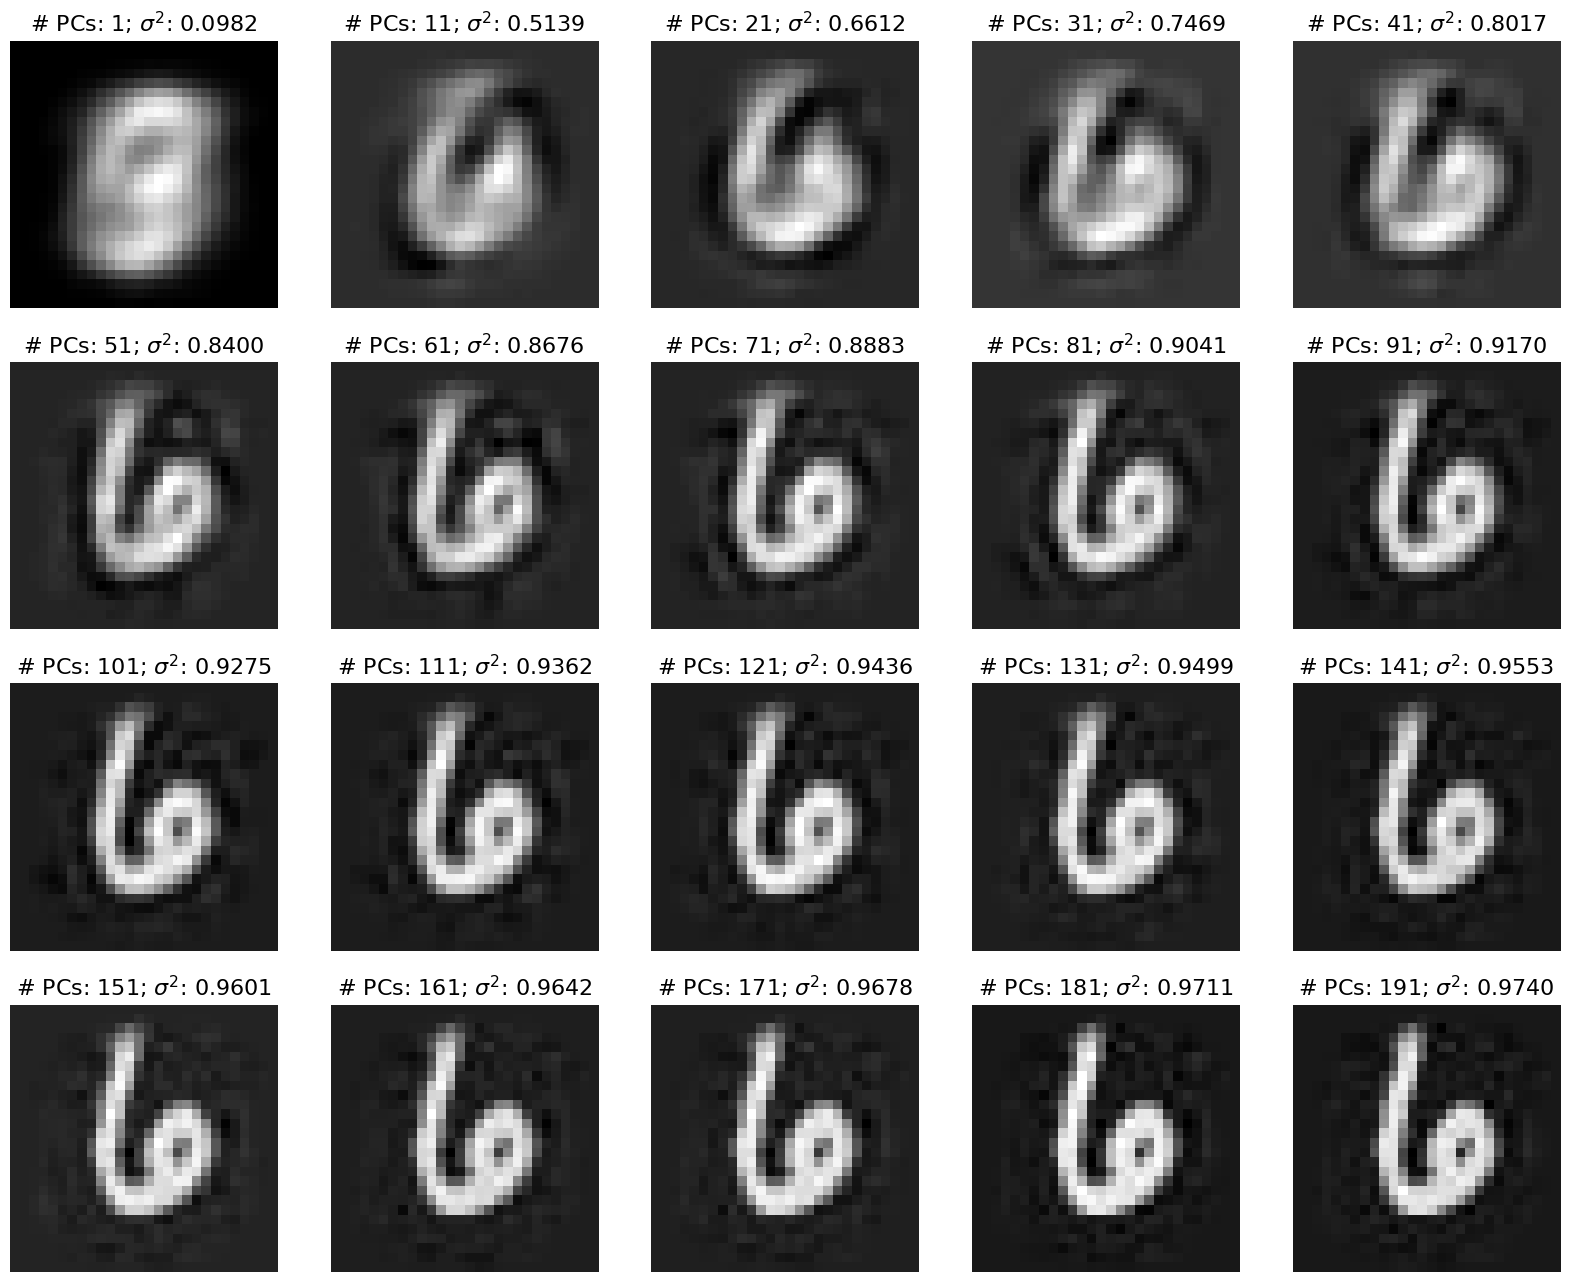

In [24]:
# Set a seed for reproducibility
seed = 87
np.random.seed(seed)

# Plot the first few principal components as images
fig, axes = plt.subplots(4, 5, figsize=(20, 16))
for i, ax in enumerate(axes.flat):
    num_components = 10*i + 1
    pca = PCA(num_components)
    data_pca = pca.fit_transform_(flattened_X)

    # Reconstruct the randomly selected image after PCA
    reconstructed_image = pca.inverse_transform_(data_pca[random_index])

    # Reshape the reconstructed data
    reconstructed_image = reconstructed_image.reshape(*original_shape, -1)

    # Calculate the variance ratio explained by the data:
    cumulative_variance_ratio = pca.cumulative_variance_ratio_()

    ax.imshow(reconstructed_image, cmap='gray')
    ax.set_title(fr'# PCs: {num_components}; $\sigma^2$: {cumulative_variance_ratio[num_components-1]:.4f}', fontsize=16)
    ax.axis('off')

plt.savefig('images/problem-1/a-random-digit-PCA.pdf')
plt.show()


In [25]:
'''Find the number of components corresponding to 95% cumulative variance
'''

def variance_threshold_to_threshold_components(variance_threshold):
    # Binary search
    left_index = 0
    right_index = num_components-1
    while left_index+1 < right_index:
        mid_index = (left_index + right_index) //2
        if(cumulative_variance_ratio[mid_index] >= variance_threshold):
            right_index = mid_index
        else:
            left_index = mid_index

    threshold_components = right_index +1

    return threshold_components

# Precompute the variances
num_components = X_train[0].flatten().size
pca = PCA(num_components)
data_pca = pca.fit_transform_(flattened_X)
cumulative_variance_ratio = pca.cumulative_variance_ratio_()

# Set threshold
variance_threshold = 0.95
threshold_components = variance_threshold_to_threshold_components(variance_threshold)

print(f'The {variance_threshold *100}% standard variance threshold is achieved by {threshold_components}# of components.')

The 95.0% standard variance threshold is achieved by 132# of components.


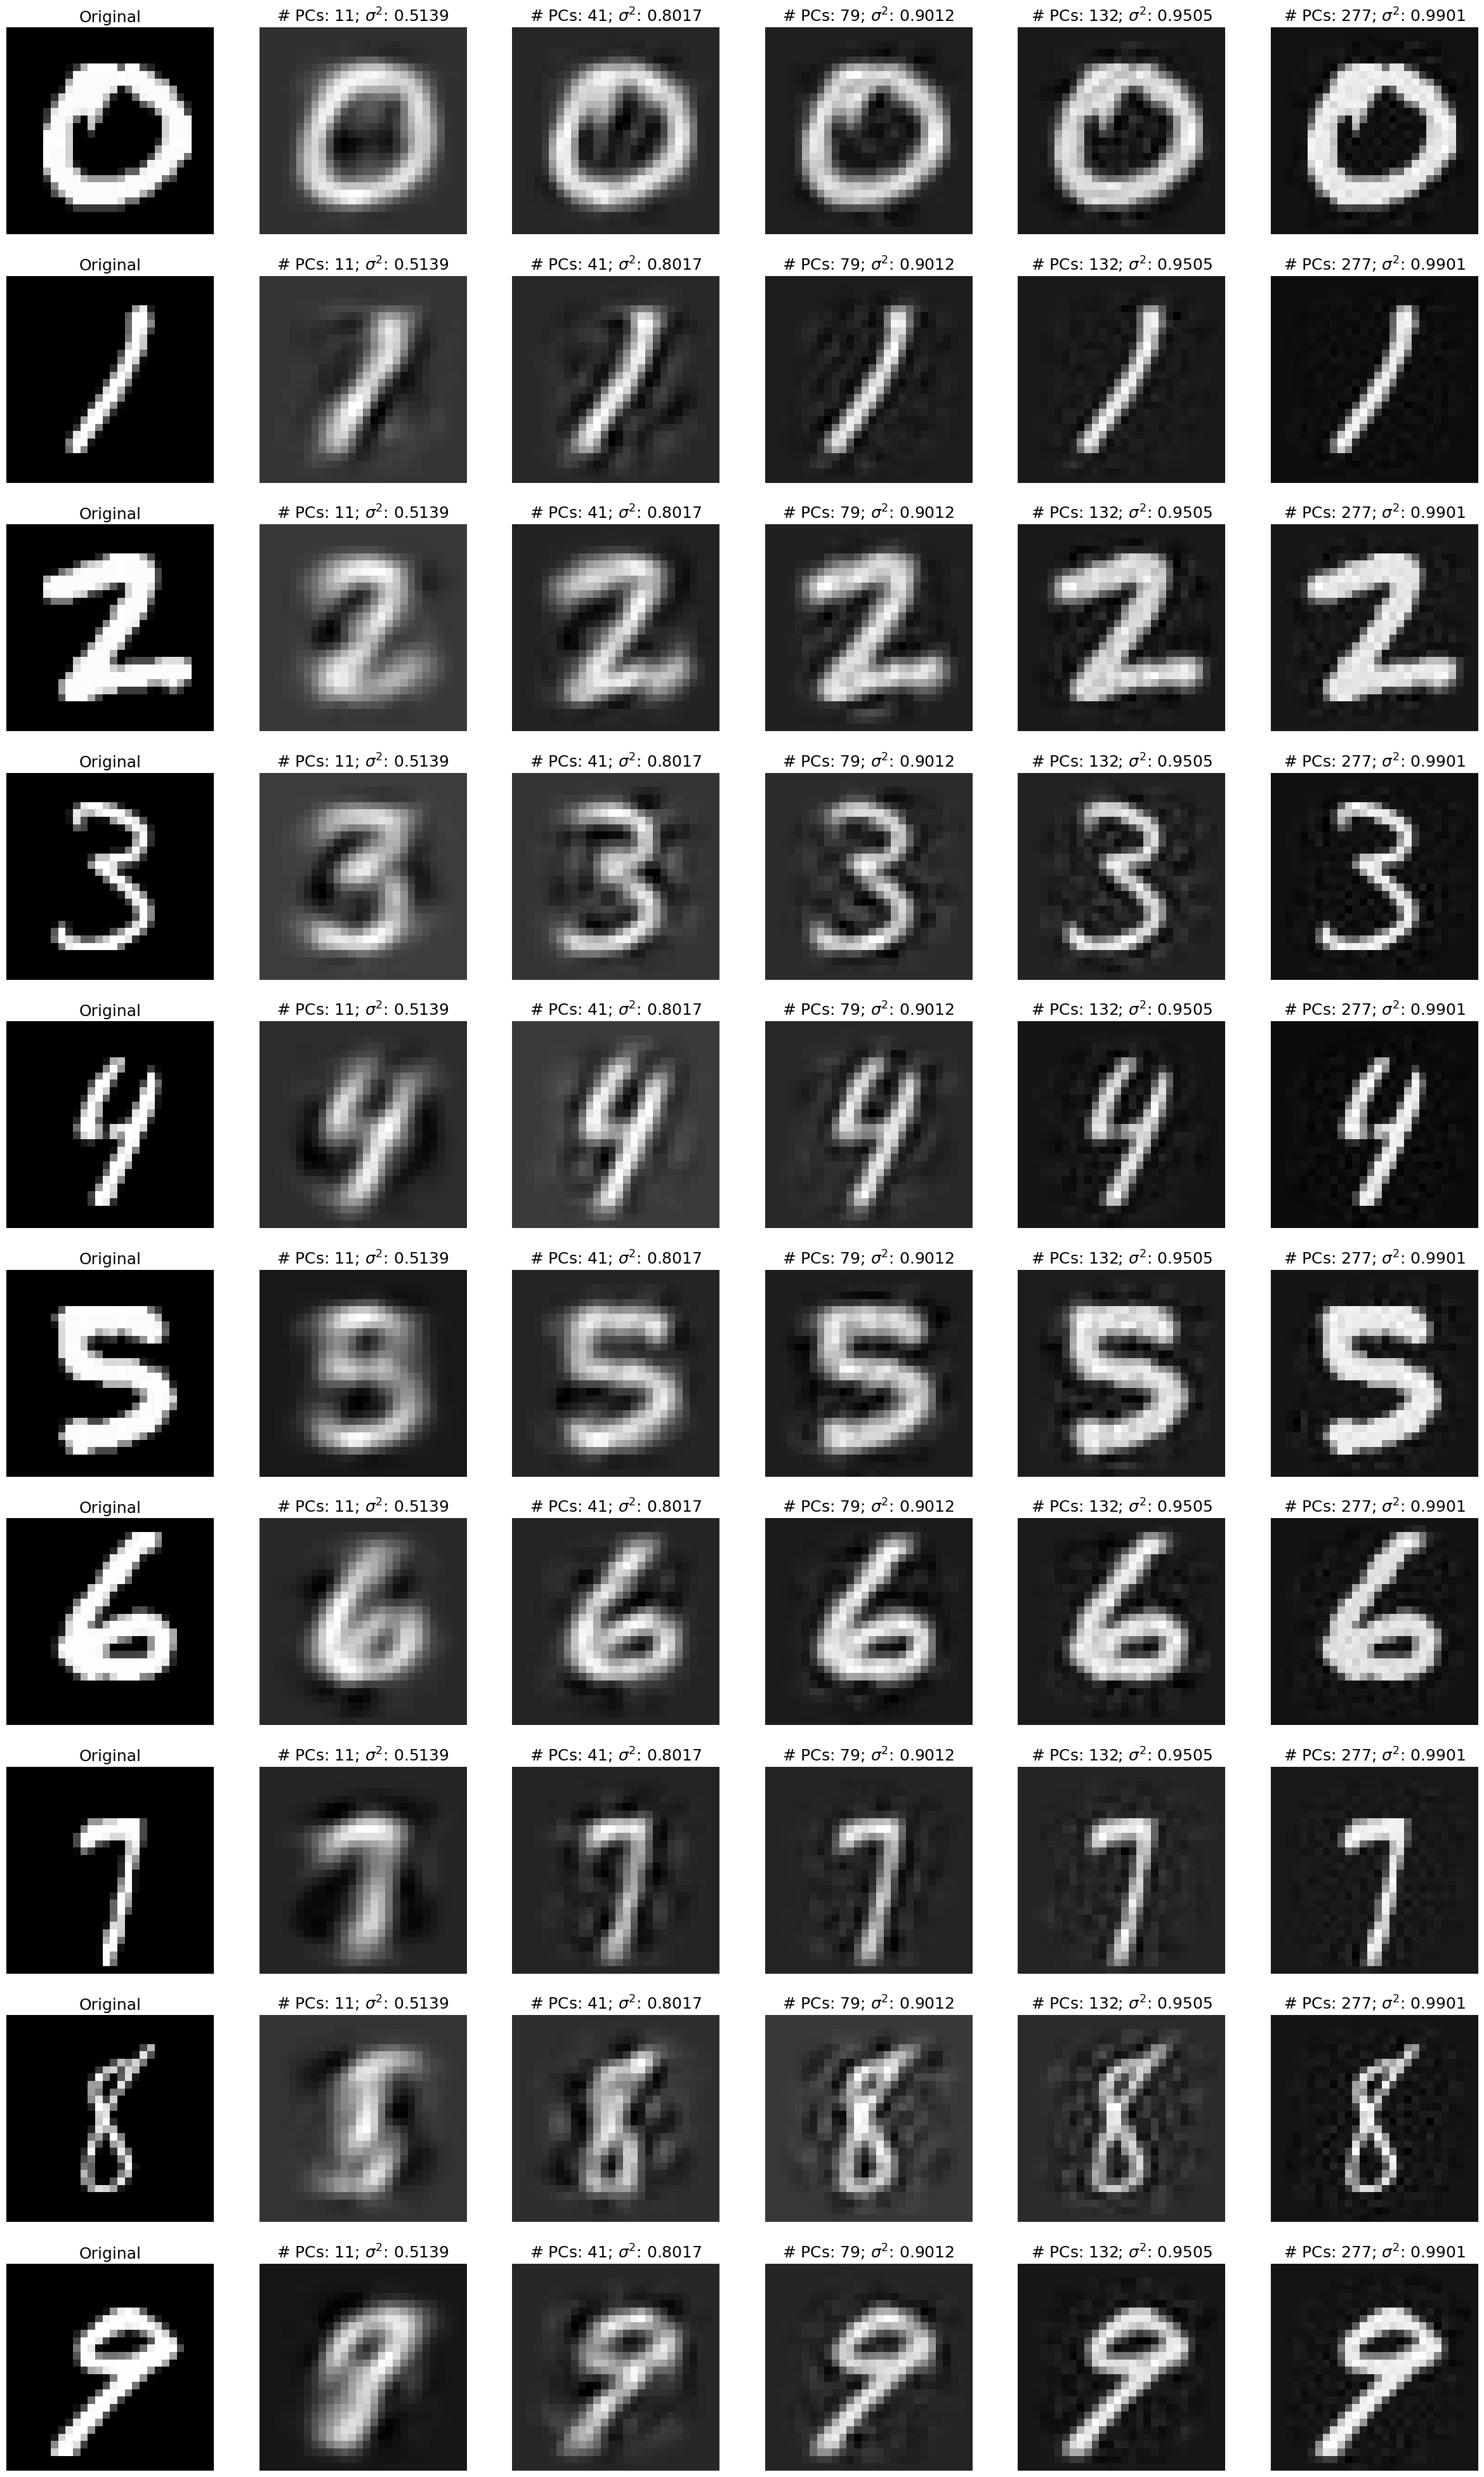

In [26]:
sample_variance_thresholds = [0.2, 0.5, 0.8, 0.9, 0.95, 0.99]

# Precompute the variances
num_components = X_train[0].flatten().size
pca = PCA(num_components)
data_pca = pca.fit_transform_(flattened_X)
cumulative_variance_ratio = pca.cumulative_variance_ratio_()

sampled_threshold_components = [variance_threshold_to_threshold_components(variance) for variance in sample_variance_thresholds]

sampled_indices = [index for label in range(10) for index in np.where(y_train == label)[0][:1]]

# Plot the first few principal components as images
fig, axes = plt.subplots(10, len(sample_variance_thresholds), figsize=(5*len(sample_variance_thresholds), 50))
for i, ax in enumerate(axes.flat):
    if i%len(sample_variance_thresholds) == 0:
        ax.imshow(X_train[sampled_indices[i//len(sample_variance_thresholds)]], cmap='gray')
        ax.set_title(f'Original', fontsize=18)
    else:
        num_components = sampled_threshold_components[i%len(sampled_threshold_components)]
        pca = PCA(num_components)
        data_pca = pca.fit_transform_(flattened_X)

        # Set index
        index = sampled_indices[i//len(sample_variance_thresholds)]

        # Reconstruct the randomly selected image after PCA
        reconstructed_image = pca.inverse_transform_(data_pca[index])

        # Reshape the reconstructed data
        reconstructed_image = reconstructed_image.reshape(*original_shape, -1)

        ax.imshow(reconstructed_image, cmap='gray')
        ax.set_title(fr'# PCs: {num_components}; $\sigma^2$: {cumulative_variance_ratio[num_components-1]:.4f}', fontsize=18)
    ax.axis('off')

plt.savefig('images/problem-1/which-lambda.pdf')
plt.show()

3. Write a piece of code to implement the Kernel PCA algorithm on this dataset. Use the following kernels :

    i. $\kappa(x,y) = (1 + x^{T}y)^d$ for $d \in \{1, 2, 3\}$
    
    ii. $\kappa(x,y) = \text{exp} \left\{\dfrac{-(x-y)^{T}(x-y)}{2\sigma^2}\right\}$ for various choices of $\sigma$ that you think are reasonable.

    Plot the projection of each point in the dataset onto the top 2 components for each kernel. Use one plot for each kernel and in the case of (b), use a different plot for each value of $\sigma$.

In [27]:
class KernelPCA(PCA):
    def __init__(self, n_components, kernel=None, gamma=None, degree=1, const_coeff=0):
        super().__init__(n_components)
        self.kernel = kernel
        self.gamma = gamma
        self.degree = degree
        self.const_coeff = const_coeff
        self.K = None

    def _compute_kernel_matrix_(self, X, Y):
        if self.kernel == 'linear':
            return np.dot(X, Y.T)
        elif self.kernel == 'rbf':
            X_norm = np.sum(X**2, axis=1, keepdims=True)
            Y_norm = np.sum(Y**2, axis=1, keepdims=True)
            return np.exp(-self.gamma * (X_norm - 2 * np.dot(X, Y.T) + Y_norm.T))
        elif self.kernel == 'poly':
            return (self.gamma * np.dot(X, Y.T) + self.const_coeff) ** self.degree
        else:
            raise ValueError('Unsupported kernel type.')

    def _center_kernel_matrix_(self, K):
        # Compute row and column means
        row_means = np.mean(K, axis=1)
        col_means = np.mean(K, axis=0)

        # Compute the overall mean
        kernel_mean = np.mean(K)

        # Center the kernel matrix
        centered_K = K - row_means[:, np.newaxis] - col_means + kernel_mean

        return centered_K

    def fit_transform_(self, X):
        # Capture X_fit
        self.X_fit = X

        # Capture the total components
        self.total_components = self.X_fit[0].size

        # Normalize the data
        centered_X, self.mean, self.std = self._centralize_data_(self.X_fit)

        # Compute the kernel matrix
        self.kernel_matrix = self._compute_kernel_matrix_(centered_X, centered_X)

        # Center the kernel matrix
        centered_kernel_matrix = self._center_kernel_matrix_(self.kernel_matrix)

        # Compute eigenvalues and eigenvectors
        self.eigenvalues, self.eigenvectors = self._compute_eigenvalues_and_vectors_(centered_kernel_matrix)

        # Select the top n_components eigenvectors
        self.components = self._select_top_eigenvectors_(self.eigenvectors)

        # Project the data onto the new feature space
        transformed_X = centered_kernel_matrix @ self.components/np.sqrt(self.eigenvalues[:self.n_components])

        return transformed_X

    def inverse_transform_(self, X_transformed):
        raise ValueError('This is kernelPCA.')

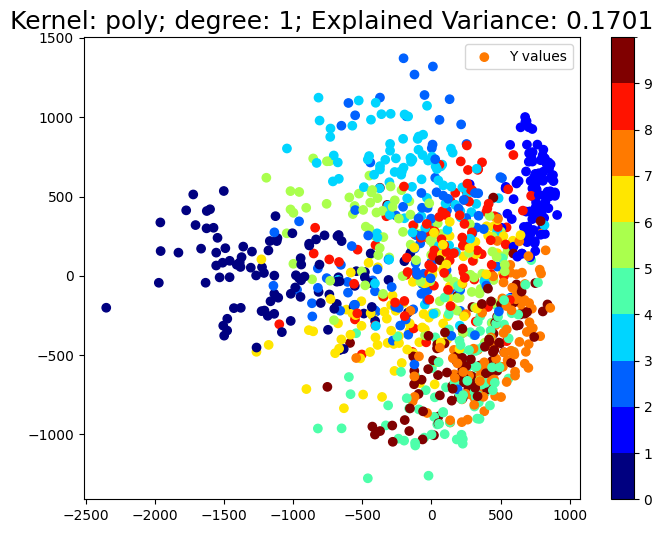

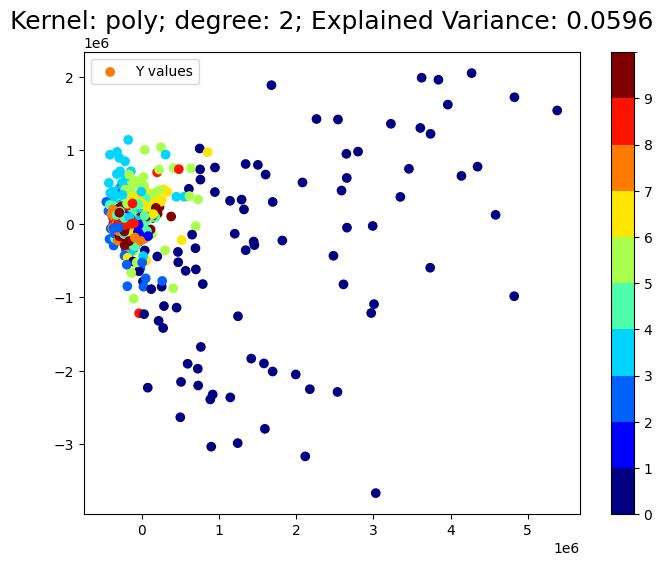

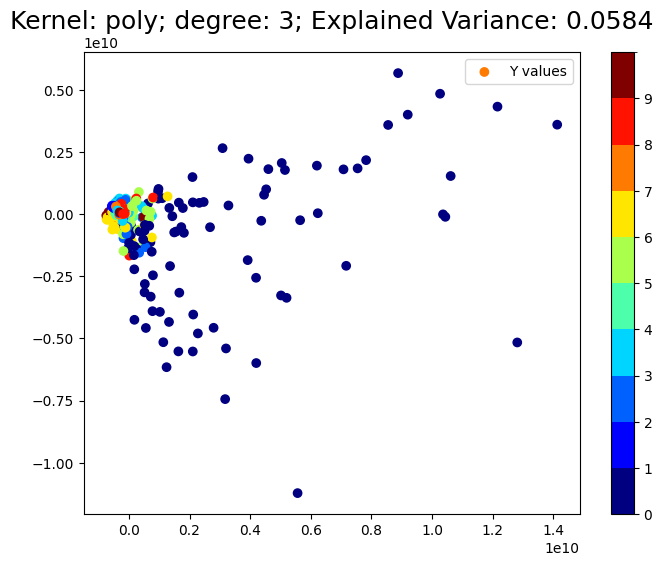

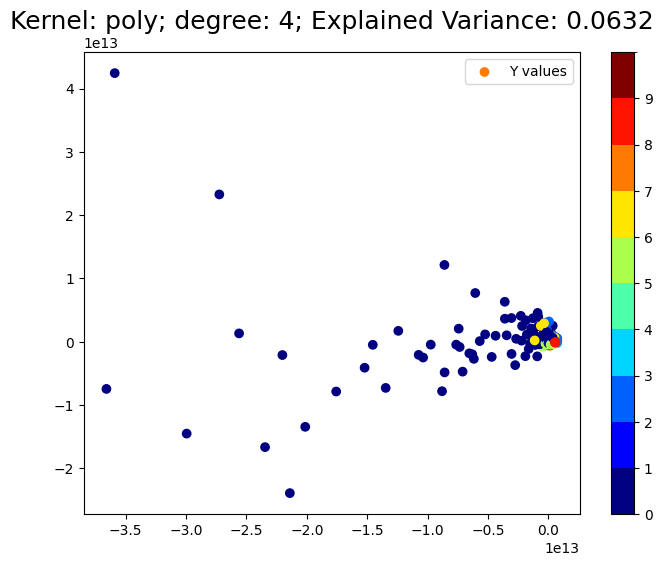

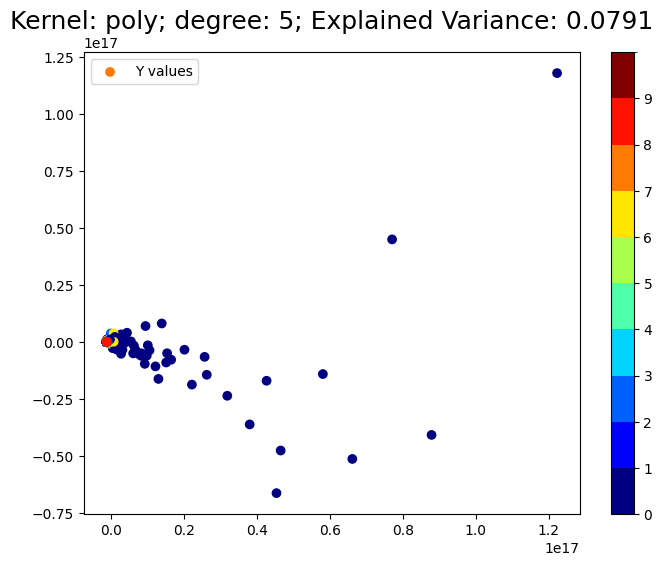

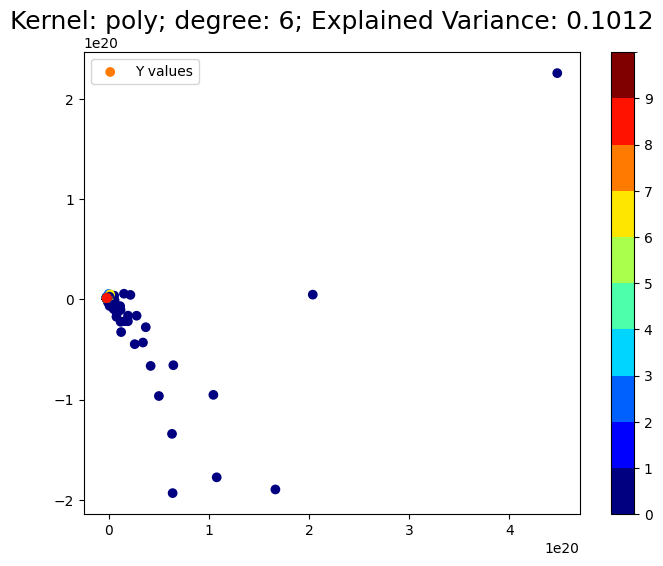

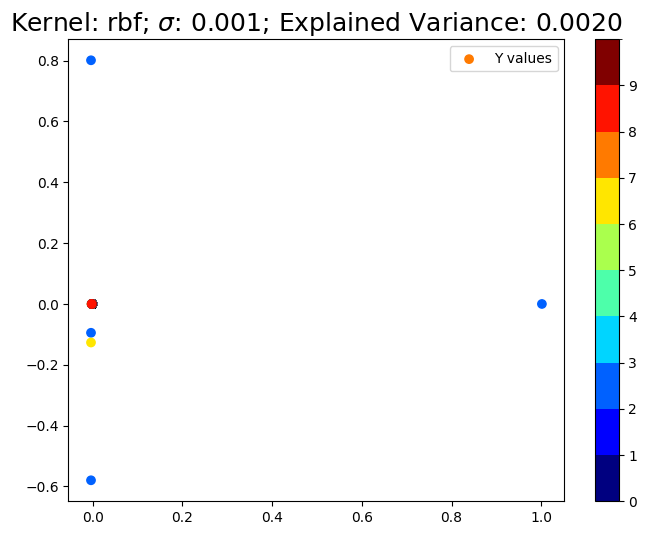

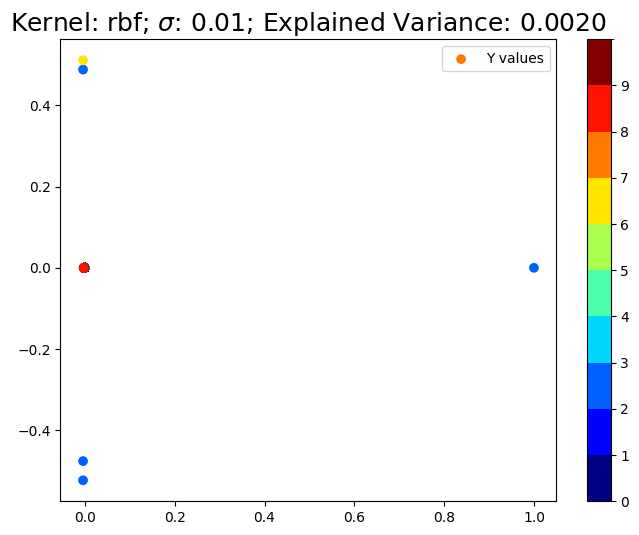

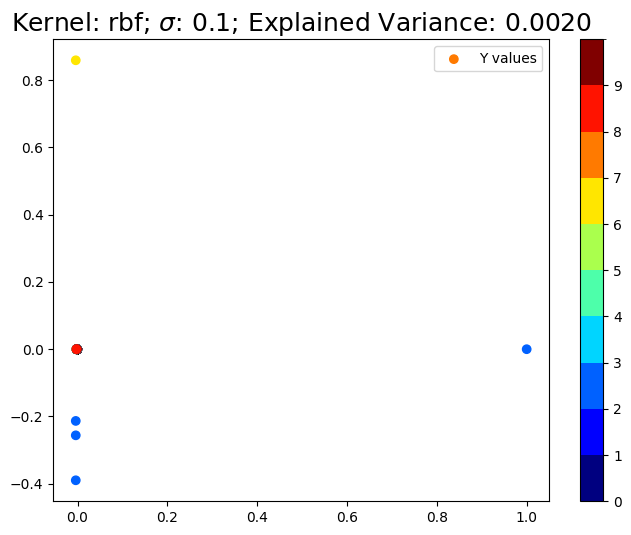

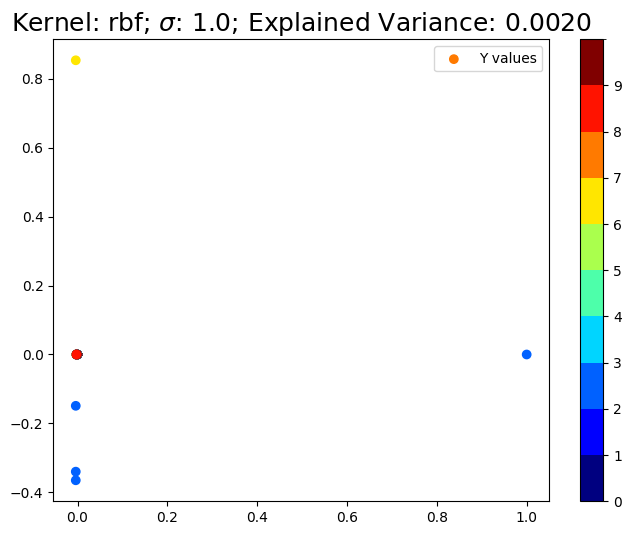

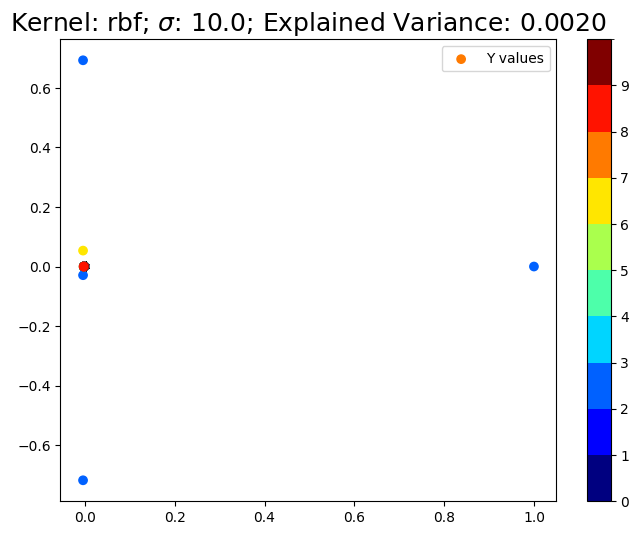

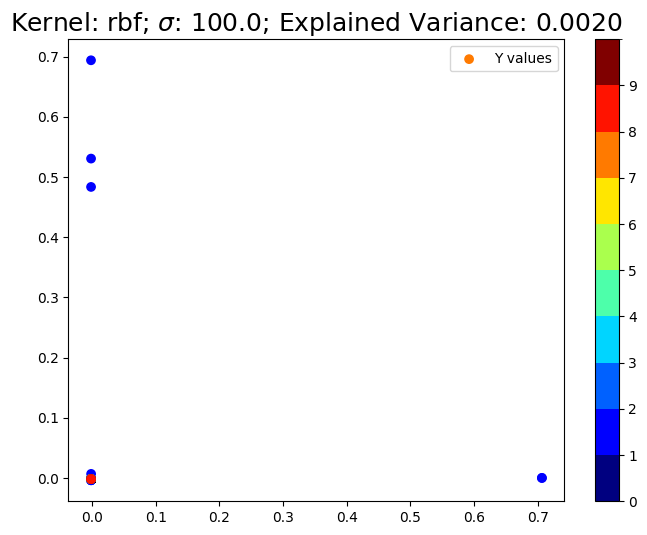

In [28]:
degrees = np.array([1, 2, 3, 4, 5, 6])
const_coeff = 1

# Chosen sigmas
sigmas = np.array([0.001, 0.01, 0.1, 1, 10, 100])
gammas = 1 / (2 * sigmas**2)

num_components = 2

# Discrete colormap for Y values
cmap = ListedColormap(plt.cm.jet(np.linspace(0, 1, 10)))
norm = BoundaryNorm(np.arange(0, 11, 1), cmap.N)

# Plot for polynomial kernel
for i, degree in enumerate(degrees):
    plt.figure(figsize=(8, 6))
    pca = KernelPCA(num_components, 'poly', gamma=1, degree=degree, const_coeff=const_coeff)
    data_pca = pca.fit_transform_(flattened_X)
    cumulative_variance_ratio = pca.cumulative_variance_ratio_()

    # Color based on Y values
    scatter = plt.scatter(data_pca[:, 0], data_pca[:, 1], c=y_train, cmap=cmap, norm=norm, label='Y values')
    plt.title(fr'Kernel: poly; degree: {degree}; Explained Variance: {cumulative_variance_ratio[num_components-1]:.4f}', fontsize=18)
    plt.legend()
    plt.colorbar(scatter, ticks=np.arange(0, 10, 1))
    plt.savefig(f'images/problem-1/KPCA-poly-{degree}.pdf')
    plt.show()

# Plot for RBF kernel
for i, sigma in enumerate(sigmas):
    plt.figure(figsize=(8, 6))
    pca = KernelPCA(num_components, 'rbf', gamma=gammas[i], degree=None, const_coeff=None)
    data_pca = pca.fit_transform_(flattened_X)
    cumulative_variance_ratio = pca.cumulative_variance_ratio_()

    # Color based on Y values
    scatter = plt.scatter(data_pca[:, 0], data_pca[:, 1], c=y_train, cmap=cmap, norm=norm, label='Y values')
    plt.title(fr'Kernel: rbf; $\sigma$: {sigma}; Explained Variance: {cumulative_variance_ratio[num_components-1]:.4f}', fontsize=18)
    plt.legend()
    plt.colorbar(scatter, ticks=np.arange(0, 10, 1))
    plt.savefig(f'images/problem-1/KPCA-rbf-{sigma}.pdf')
    plt.show()